Pork Chop Plots
=====
#####Version 0.1
We went to Mars in Tutorial0, using an MGA-1DSM trajectory model, only to discover the final solutions did not make use of the Deep Space Manouvre. It than makes sense to explore the trajectory space using a simpler (and much faster) trajectory model. In this tutorial we will make use of Lambert transfers to study a Mars mission, producing the so called Pork-Chop plots extensively used in missions such as Voyager.

### Import statments
***


https://esa.github.io/pykep/system.html

https://naif.jpl.nasa.gov/pub/naif/toolkit//C/MacIntel_OSX_AppleC_64bit/packages/README

In [76]:
import pygmo as pg
import pykep as pk
from matplotlib import pyplot as plt
import numpy as np
from scipy import array
import pandas as pd

### Grid search
***

We will start sampling departure epochs and transfer times each fifteen days and solve the Lambert problem in a large defined grid.

In [90]:
start_date = 7400.0 
end_date = 10000.0
start_epochs = np.arange(start_date, end_date, 15.0)

date_range = pd.to_datetime(start_epochs, unit='d', origin=pd.Timestamp('2000-01-01'))
date_range

DatetimeIndex(['2020-04-05', '2020-04-20', '2020-05-05', '2020-05-20',
               '2020-06-04', '2020-06-19', '2020-07-04', '2020-07-19',
               '2020-08-03', '2020-08-18',
               ...
               '2026-12-30', '2027-01-14', '2027-01-29', '2027-02-13',
               '2027-02-28', '2027-03-15', '2027-03-30', '2027-04-14',
               '2027-04-29', '2027-05-14'],
              dtype='datetime64[ns]', length=174, freq=None)

In [91]:
start_date = 7400.0
end_date = 10000.0
start_epochs = np.arange(start_date, end_date, 15.0)
duration = np.arange(180.0,470.0,15.0)
#earth = pk.planet.spice('EARTH', 'SUN', 'ECLIPJ2000', 'NONE',
                         #pk.MU_SUN, pk.MU_EARTH, 6371000, 6371000 * 1.05)

earth = pk.planet.jpl_lp('earth')
mars = pk.planet.jpl_lp('mars')

data = list()
for start in start_epochs:
    row = list()
    for T in duration:
        r1,v1 = earth.eph(pk.epoch(start, 'mjd2000'))
        r2,v2 = mars.eph(pk.epoch(start+T, 'mjd2000'))
        l = pk.lambert_problem(r1,r2,T*60*60*24,earth.mu_central_body)
        DV1 = np.linalg.norm( array(v1)-array(l.get_v1()[0]) )
        DV2 = np.linalg.norm( array(v2)-array(l.get_v2()[0]) )
        DV1 = max([0,DV1-4000])
        DV = DV1+DV2
        row.append(DV)
    data.append(row)

<ipython-input-91-b7cebb044b4f>:18: DeprecationWarning:

scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead

<ipython-input-91-b7cebb044b4f>:19: DeprecationWarning:

scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead



And we extract the best solution found and the relative epochs:

In [92]:
minrows = [min(l) for l in data]
i_idx = np.argmin(minrows)
j_idx = np.argmin(data[i_idx])
best = data[i_idx][j_idx]
print("Best DV: " + str(best) + " m/s")
print("Launch epoch (MJD2000): " +  str(start_epochs[i_idx]))
print("Duration (days): " +  str(duration[j_idx]))


Best DV: 2426.7523217356197 m/s
Launch epoch (MJD2000): 9020.0
Duration (days): 330.0


And we plot the result:

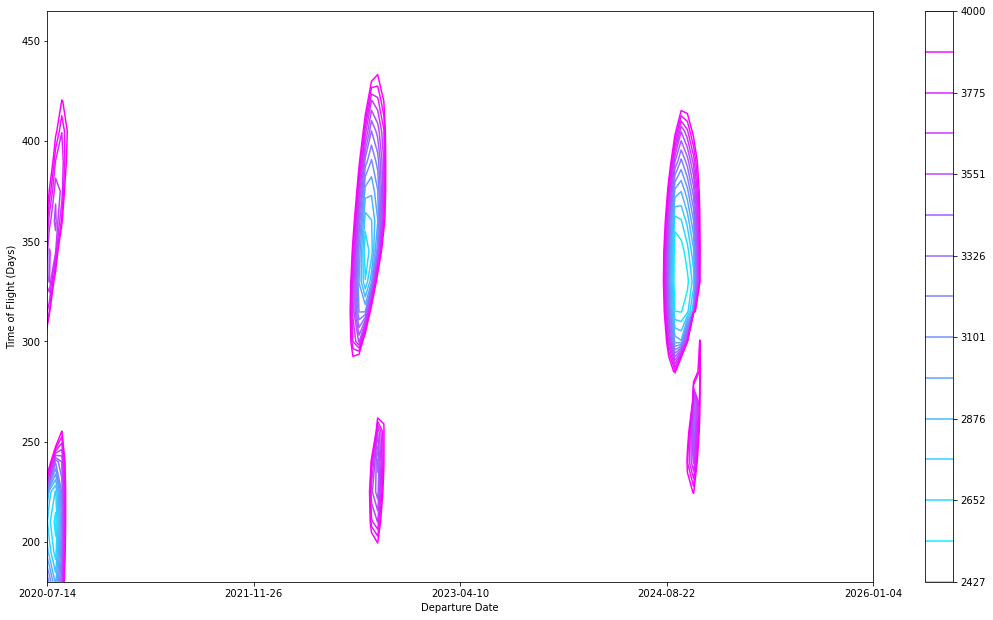

In [93]:
duration_pl, start_epochs_pl = np.meshgrid(duration, start_epochs)
plt.contour(start_epochs_pl,
            duration_pl,
            np.array(data),
            levels = list(np.linspace(best, 4000, 15)),
            cmap = 'cool')

plt.colorbar()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.xlabel('Departure Date')
plt.ylabel('Time of Flight (Days)')
new_labels = [str(i)[:10] for i in pd.to_datetime(plt.xticks()[0], unit='d', origin=pd.Timestamp('2000-01-01')).values]
plt.xticks(ticks = plt.xticks()[0], labels = new_labels)
plt.xlim(7500, 9500)
plt.show()

In [94]:
date_vals = [str(i)[:10] for i in pd.to_datetime([i[0] for i in start_epochs_pl], unit='d', origin=pd.Timestamp('2000-01-01')).values]

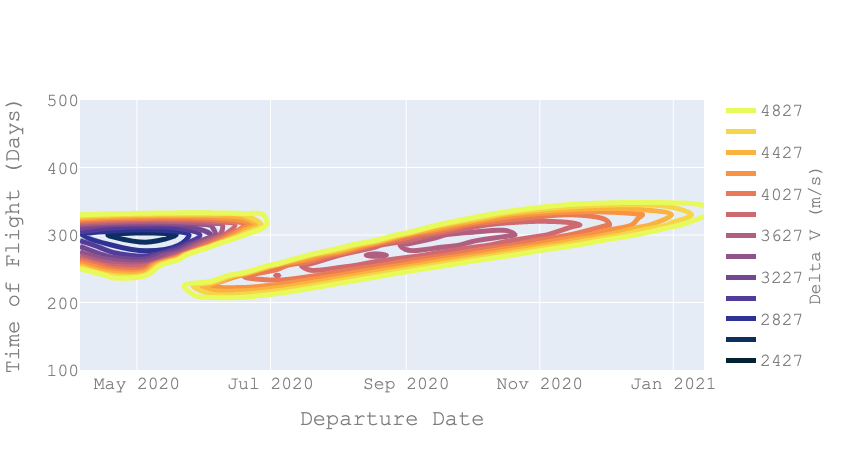

In [96]:
import plotly.graph_objects as go
duration_pl, start_epochs_pl = np.meshgrid(duration, start_epochs)


fig = go.Figure(data =
    go.Contour(
        z = np.array(data),
        x = date_vals, # horizontal axis
        y = duration_pl[0], # vertical axis
        colorscale='thermal',
        contours=dict(
            start=best,
            end=5000,
            size=200,
        ),
        colorbar=dict(
            title='Delta V (m/s)', # title here
            titleside='right',
            titlefont=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"
                )
        ),
        contours_coloring='lines',
        line_width=5,
        
    ))


fig.update_layout(
    xaxis_title="Departure Date",
    yaxis_title="Time of Flight (Days)",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)

#fig.update_xaxes(nticks=20)
fig.update_yaxes(range=[100, 500])


fig.show()

We may now *zoom in* one of the launch windows (for example the best one) sampling the epochs with a finer resolution. We thus repeat what done previously ....

In [83]:
start_epochs = np.arange(8950.0,9100.0,1.0)
duration = np.arange(200.0,450.0,1.0)
data = list()
for start in start_epochs:
    row = list()
    for T in duration:
        r1,v1 = earth.eph(pk.epoch(start))
        r2,v2 = mars.eph(pk.epoch(start+T))
        l = pk.lambert_problem(r1,r2,T*60*60*24,earth.mu_central_body)
        DV1 = np.linalg.norm( array(v1)-array(l.get_v1()[0]) )
        DV2 = np.linalg.norm( array(v2)-array(l.get_v2()[0]) )
        DV1 = max([0,DV1-4000])
        DV = DV1+DV2
        row.append(DV)
    data.append(row)

<ipython-input-83-7882f9acd8e8>:10: DeprecationWarning:

scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead

<ipython-input-83-7882f9acd8e8>:11: DeprecationWarning:

scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead



In [84]:
minrows = [min(l) for l in data]
i_idx = np.argmin(minrows)
j_idx = np.argmin(data[i_idx])
best = data[i_idx][j_idx]
print("Best DV: " + str(best))
print("Launch epoch (MJD2000): " +  str(start_epochs[i_idx]))
print("Duration (days): " +  str(duration[j_idx]))

Best DV: 2415.8146772099876
Launch epoch (MJD2000): 9026.0
Duration (days): 334.0


Note the effect of the sampling resolution on the best found opportunity ..... we now use an interactive plot to visualize this launch opportunity.

In [20]:
duration_pl2, start_epochs_pl2 = np.meshgrid(duration, start_epochs)
def pork_chop(cut=2700):
    plt.contour(start_epochs_pl2,duration_pl2,array(data),levels = [cut]+list(np.linspace(2500,4000,4)))
    plt.colorbar()
    plt.show()
w = interactive(pork_chop,cut=(best,2*best))
display(w)

NameError: name 'interactive' is not defined

In [1]:
def create_pork_chop_plot(start_date, end_date, origin = 'earth', destination = 'mars'):

    # Epoch range (x axis)
    if start_date == 'start_date':
        start_date = "2020-04-01"
        end_date = "2021-01-01"
    parsed_start_date = dt.strptime(start_date, '%Y-%m-%d').date()
    parsed_end_date = dt.strptime(end_date, '%Y-%m-%d').date()
    initial_epoch_date = datetime.date(2000, 1, 1)

    start_epoch = float((parsed_start_date - initial_epoch_date).days)
    end_date = float((parsed_end_date - initial_epoch_date).days)
    start_epochs = np.arange(start_epoch, end_date, 15.0)

    # Time of flight (y axis)
    duration = np.arange(180.0, 470.0, 15.0)

    # Origin
    earth = pk.planet.jpl_lp(origin)
    # Destination
    mars = pk.planet.jpl_lp(destination)

    data = list()
    for start in start_epochs:
        row = list()
        for T in duration:
            r1,v1 = earth.eph(pk.epoch(start, 'mjd2000'))
            r2,v2 = mars.eph(pk.epoch(start+T, 'mjd2000'))
            l = pk.lambert_problem(r1, r2, T*60*60*24, earth.mu_central_body)
            DV1 = np.linalg.norm(np.array(v1) - np.array(l.get_v1()[0]))
            DV2 = np.linalg.norm(np.array(v2) - np.array(l.get_v2()[0]))
            DV1 = max([0, DV1 - 4000])
            DV = DV1 + DV2
            row.append(DV)
        data.append(row)

    minrows = [min(l) for l in data]
    i_idx = np.argmin(minrows)
    j_idx = np.argmin(data[i_idx])

    duration_pl, start_epochs_pl = np.meshgrid(duration, start_epochs)

    date_series = pd.to_datetime([i[0] for i in start_epochs_pl],
        unit='d',
        origin=pd.Timestamp('2000-01-01')
        )

    date_vals = [str(i)[:10] for i in date_series.values]

    fig = go.Figure(data =
        go.Contour(
            z = np.array(data),
            x = date_vals, # horizontal axis
            y = duration_pl[0], # vertical axis
            colorscale = 'thermal',
            contours = dict(
                start = data[i_idx][j_idx],
                end = 5000,
                size = 200,
            ),
            colorbar = dict(
                title = 'Delta V (m/s)', # title here
                titleside = 'right',
                titlefont = dict(
                    family = "Courier New, monospace",
                    size = 18,
                    color = "#7f7f7f"
                    )
            ),
            contours_coloring = 'lines',
            line_width  =5,

        ))


    fig.update_layout(
        xaxis_title = "Departure Date",
        yaxis_title = "Time of Flight (Days)",
        font = dict(
            family = "Courier New, monospace",
            size = 18,
            color = "#7f7f7f"
        )
    )

    fig.update_yaxes(range = [100, 500])

    return fig

In [22]:
import datetime  as dt
from datetime import datetime

start_date = '2020-03-28'

parsed_start_date = datetime.strptime(start_date, "%Y-%m-%d").date()
initial_epoch_date = dt.date(2000, 1, 1)

start_epoch = (parsed_start_date - initial_epoch_date).days

7392

datetime.timedelta(days=-7392)

In [ ]:
create_pork_chop_plot(start_date, end_date, origin, destination):